## 提取数据

In [4]:
import numpy as np
import torch
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from sklearn.preprocessing import normalize
import pandas as pd

### CPU版本

In [5]:
import torch
import pandas as pd

# —— 1. 强制全程在 CPU —— 
device = torch.device("cpu")
print(f" 当前设备强制为：{device}")

# 加载 logits 文件到 CPU
ans_list, all_step_probs = torch.load(
    "E:/math500_logits_llama_500.pt",
    map_location="cpu"
)

# 明确 all_step_probs 保持在 CPU
all_step_probs = all_step_probs.to("cpu")
print(f"all_step_probs device: {all_step_probs.device}")

# —— 2. 加载 CSV 标签，并转成 CPU tensor —— 
csv_path = "E:/math500_500_llama.pt.csv"
df = pd.read_csv(csv_path)

# verdict -> 0/1
df['label'] = df['verdict'].str.lower().map({'correct': 1, 'incorrect': 0})

# 构建 label tensor，并放到 CPU
label_tensor = torch.tensor(
    df['label'].values,
    dtype=torch.float32
).unsqueeze(1)  # 默认就在 CPU

print(f"label_tensor device: {label_tensor.device}")

# —— 3. 拼接 logits 和 label —— 
assert all_step_probs.shape[0] == label_tensor.shape[0], "样本数量不一致，不能拼接！"
combined = torch.cat([all_step_probs, label_tensor], dim=1)

print(f" Combined shape: {combined.shape}")
print(f" Combined device: {combined.device}")

 当前设备强制为：cpu
all_step_probs device: cpu
label_tensor device: cpu
 Combined shape: torch.Size([500, 128257])
 Combined device: cpu


### GPU版本

In [1]:
import torch
import pandas as pd

# —— 1. 强制全程在 GPU，如果可用 —— 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" 当前设备：{device}")

# 加载 logits 文件到 GPU（注意 map_location 设置为 device）
ans_list, all_step_probs = torch.load(
    "/mnt/e/gsm8k_logits_llama_7473.pt",
    map_location=device
)

# 明确将 all_step_probs 放到 GPU
all_step_probs = all_step_probs.to(device)
print(f"all_step_probs device: {all_step_probs.device}")

# —— 2. 加载 CSV 标签，并转成 GPU tensor —— 
csv_path = "/mnt/e/gsm8k_7473_llama.pt.csv"
df = pd.read_csv(csv_path)

# verdict -> 0/1
df['label'] = df['verdict'].str.lower().map({'correct': 1, 'incorrect': 0})

# 构建 label tensor，并放到 GPU
label_tensor = torch.tensor(
    df['label'].values,
    dtype=torch.float32
).unsqueeze(1).to(device)

print(f"label_tensor device: {label_tensor.device}")

# —— 3. 拼接 logits 和 label —— 
assert all_step_probs.shape[0] == label_tensor.shape[0], "样本数量不一致，不能拼接！"
combined = torch.cat([all_step_probs, label_tensor], dim=1)

print(f" Combined shape: {combined.shape}")
print(f" Combined device: {combined.device}")


🚀 当前设备：cuda
all_step_probs device: cuda:0
label_tensor device: cuda:0
✅ Combined shape: torch.Size([7473, 128257])
✅ Combined device: cuda:0


## 数据预处理

### 方法1：根据top_10words重建词表

#### CPU版本

In [6]:
import numpy as np
import torch

def extract_top_k_vocab(X, vocab_list, top_k):
    """
    对每行选出 top_k 最大值对应的列索引，合并去重后构造新的词表和矩阵。

    参数：
        X: 2D 矩阵，支持 numpy array 或 torch.Tensor，形状 [N, V]
        vocab_list: 原始词表，长度为 V
        top_k: 每行保留前 top_k 高概率的列索引

    返回：
        new_vocab_list: 精简后的词表（去重后的 top-k 所在列）
        new_X: 新的 NumPy 矩阵，仅包含 new_vocab_list 对应的列
    """
    # 转换为 NumPy 矩阵
    if isinstance(X, torch.Tensor):
        X_np = X.detach().cpu().numpy()
    else:
        X_np = np.asarray(X)

    # 每行取 top_k 最大值索引
    topk_idx_matrix = np.argpartition(-X_np, kth=top_k - 1, axis=1)[:, :top_k]

    # 合并所有行的索引，并去重排序
    unique_indices = np.unique(topk_idx_matrix.flatten())
    unique_indices_sorted = np.sort(unique_indices)

    # 构建新词表
    new_vocab_list = [vocab_list[i] for i in unique_indices_sorted]

    # 构建新矩阵：保留这些列
    new_X = X_np[:, unique_indices_sorted]

    return new_vocab_list, new_X


In [7]:
X = all_step_probs
y = df["label"].to_numpy()

vocab_list = [f"word_{i}" for i in range(X.shape[1])]
new_vocab_list, new_X = extract_top_k_vocab(X, vocab_list, top_k=10)

print("原始词表大小：", len(vocab_list))
print("新词表大小：", len(new_vocab_list))
print("新矩阵形状：", new_X.shape)

X=new_X

原始词表大小： 128256
新词表大小： 876
新矩阵形状： (500, 876)


#### GPU版本

In [2]:
import torch

def extract_top_k_vocab_gpu(X, vocab_list, top_k):
    """
    在 GPU 上运行的提取 top-k 词表版本。
    
    参数：
        X: torch.Tensor, shape [N, V]，应在 GPU 上
        vocab_list: 原始词表，长度为 V
        top_k: 每行保留前 top_k 高概率 token

    返回：
        new_vocab_list: 精简后的词表（去重的 top-k token 列索引）
        new_X: 精简后的 torch.Tensor，仅包含选中的列（仍在 GPU 上）
    """
    assert isinstance(X, torch.Tensor), "X 必须是 torch.Tensor"
    assert X.is_cuda, "X 必须在 GPU 上"

    # 每行取 top_k 最大值的列索引
    topk_indices = torch.topk(X, k=top_k, dim=1).indices  # shape: [N, top_k]

    # Flatten 并去重
    unique_indices = torch.unique(topk_indices)
    unique_indices_sorted, _ = torch.sort(unique_indices)

    # 构建新词表
    new_vocab_list = [vocab_list[i] for i in unique_indices_sorted.tolist()]

    # 按列索引提取新矩阵
    new_X = X[:, unique_indices_sorted]

    return new_vocab_list, new_X


In [4]:
# 假设 all_step_probs 已经在 GPU 上
X = all_step_probs  # shape [N, V]
y = df["label"].to_numpy()

# 原始词表
vocab_list = [f"word_{i}" for i in range(X.shape[1])]

# 提取 GPU 上 top-k 精简词表和矩阵
new_vocab_list, new_X = extract_top_k_vocab_gpu(X, vocab_list, top_k=10)

print("原始词表大小：", len(vocab_list))
print("新词表大小：", len(new_vocab_list))
print("新矩阵形状：", new_X.shape)

# 更新 X
X = new_X


原始词表大小： 128256
新词表大小： 3679
新矩阵形状： torch.Size([7473, 3679])


## 数据集划分

In [8]:
from sklearn.model_selection import train_test_split

# 随机划分：80% 训练集，20% 测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 测试集占 20%
    random_state=42,     # 固定随机种子，保证可复现
)

print(f"训练集样本数: {X_train.shape[0]}，测试集样本数: {X_test.shape[0]}")

训练集样本数: 400，测试集样本数: 100


## 逻辑回归+L2 penalty+加权处理类别不平衡（降维后）

In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_auc_score
)
import os
import tempfile
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# —— 0. joblib 临时目录（可选） —— 
joblib_tmp_dir = "D:/joblib_temp"
os.makedirs(joblib_tmp_dir, exist_ok=True)
os.environ['JOBLIB_TEMP_FOLDER'] = joblib_tmp_dir
tempfile.tempdir = joblib_tmp_dir

# —— 1. 定义模型 & GridSearchCV —— 
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'C': C_values, 'penalty': ['l2'], 'solver': ['saga']}
base_clf = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
grid = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# —— 2. 确保数据在 CPU 上的 NumPy —— 
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    return x

X_train_np = to_numpy(X_train)
y_train_np = to_numpy(y_train)
X_test_np  = to_numpy(X_test)
y_test_np  = to_numpy(y_test)

# —— 3. 训练 —— 
print("开始在 CPU 上训练 GridSearchCV …")
grid.fit(X_train_np, y_train_np)

best_model = grid.best_estimator_
print(" Best params:", grid.best_params_)
print("交叉验证最佳准确率：", grid.best_score_)

# —— 4. 使用全集进行评估 —— 
X_np = to_numpy(X)
y_np = to_numpy(y)

# 默认阈值 0.5
y_pred_05 = best_model.predict(X_np)
print("\n[默认阈值 0.5] Accuracy:", accuracy_score(y_np, y_pred_05))
print(classification_report(y_np, y_pred_05, zero_division=0))

# —— 5. 阈值搜索（基于全集）—— 
probs = best_model.predict_proba(X_np)[:, 1]
thresholds = np.arange(0.0, 1.0 + 0.001, 0.001)

best_t, best_acc = 0.5, 0.0
for t in thresholds:
    y_pred_t = (probs >= t).astype(int)
    acc = accuracy_score(y_np, y_pred_t)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print(f" 最优阈值（按 Accuracy 最大化，步长=0.001）：{best_t:.3f}，对应 Accuracy={best_acc:.4f}")

# 最优阈值评估
y_pred_opt = (probs >= best_t).astype(int)

acc_opt   = accuracy_score(y_np, y_pred_opt)
f1_opt    = f1_score(y_np, y_pred_opt, zero_division=0)
auc_score = roc_auc_score(y_np, probs)

print("\n 最终指标（在最优阈值下，全体样本）：")
print(f"Accuracy: {acc_opt:.4f}")
print(f"F1-score: {f1_opt:.4f}")
print(f"AUC:       {auc_score:.4f}")

开始在 CPU 上训练 GridSearchCV …
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Best params: {'C': 100.0, 'penalty': 'l2', 'solver': 'saga'}
交叉验证最佳准确率： 0.77

[默认阈值 0.5] Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       143
           1       0.89      0.92      0.91       357

    accuracy                           0.86       500
   macro avg       0.84      0.82      0.83       500
weighted avg       0.86      0.86      0.86       500

 最优阈值（按 Accuracy 最大化，步长=0.001）：0.321，对应 Accuracy=0.8760

 最终指标（在最优阈值下，全体样本）：
Accuracy: 0.8760
F1-score: 0.9186
AUC:       0.8589


In [7]:
acc_opt_log=acc_opt
f1_opt_log=f1_opt
auc_opt_log=auc_score

## 支持向量机

### 线性核

In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)

def compute_svc_metrics(clf, X_test, y_test):
    """
    计算线性 SVC 的 Accuracy、F1-score 和 AUC，并作为返回值返回。
    """
    # 1. 预测标签
    y_pred = clf.predict(X_test)
    # 2. 决策函数得分（用于 AUC）
    y_scores = clf.decision_function(X_test)
    
    # 3. 计算指标
    acc = accuracy_score(y_test,   y_pred)
    f1  = f1_score(y_test,        y_pred, zero_division=0)
    auc = roc_auc_score(y_test,   y_scores)
    
    return acc, f1, auc

# —— 使用示例 —— 
acc_opt_linear, f1_opt_linear, auc_opt_linear = compute_svc_metrics(clf, X, y)

print(f"Accuracy         = {acc_opt_linear:.4f}")
print(f"F1-score         = {f1_opt_linear:.4f}")
print(f"AUC (ROC AUC)    = {auc_opt_linear:.4f}")

Accuracy         = 0.8660
F1-score         = 0.9124
AUC (ROC AUC)    = 0.8389


### 多项式核

#### CPU版本

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#  确保是 numpy 格式
X_train = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
X_test = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

#  网格参数
C_values = [0.01, 0.1, 1.0, 10.0]
degrees = [2, 3, 4]
coef0_values = [0.0, 1.0]
param_grid = [(C, d, c0) for C in C_values for d in degrees for c0 in coef0_values]

#  交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for C, degree, coef0 in param_grid:
    print(f"\n Grid Search: C={C}, degree={degree}, coef0={coef0}")
    acc_list, f1_list, auc_list = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        try:
            model = SVC(
                kernel='poly',
                C=C,
                degree=degree,
                coef0=coef0,
                probability=True,
                random_state=42,
                max_iter=10000
            )
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:, 1]

            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')
            auc = roc_auc_score(y_val, y_proba)

            acc_list.append(acc)
            f1_list.append(f1)
            auc_list.append(auc)
        except Exception as e:
            print(f"   Fold {fold+1} 出错: {e}")
            acc_list.append(np.nan)
            f1_list.append(np.nan)
            auc_list.append(np.nan)

    mean_acc = np.nanmean(acc_list)
    mean_f1 = np.nanmean(f1_list)
    mean_auc = np.nanmean(auc_list)
    results.append((C, degree, coef0, mean_acc, mean_f1, mean_auc))
    print(f" CV 平均：Acc={mean_acc:.4f}, F1={mean_f1:.4f}, AUC={mean_auc:.4f}")

#  最佳参数
valid_results = [r for r in results if not np.isnan(r[4])]
best = max(valid_results, key=lambda x: x[4])
best_C, best_degree, best_coef0 = best[:3]

print("\n 最佳参数：C=%.3f, degree=%d, coef0=%.1f" % (best_C, best_degree, best_coef0))

#  在训练集上重训，在测试集上评估
model_test = SVC(
    kernel='poly',
    C=best_C,
    degree=best_degree,
    coef0=best_coef0,
    probability=True,
    random_state=42
)
model_test.fit(X_train, y_train)
y_pred_test = model_test.predict(X_test)
y_proba_test = model_test.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='macro')
auc_test = roc_auc_score(y_test, y_proba_test)

print("\n 测试集评估：")
print(f" Accuracy = {acc_test:.4f}")
print(f" F1-score = {f1_test:.4f}")
print(f" AUC      = {auc_test:.4f}")

#  重新在全集上训练并输出最终评估
X_full = np.vstack([X_train, X_test])
y_full = np.hstack([y_train, y_test])

model_final = SVC(
    kernel='poly',
    C=best_C,
    degree=best_degree,
    coef0=best_coef0,
    probability=True,
    random_state=42
)
model_final.fit(X_full, y_full)
y_pred_full = model_final.predict(X_full)
y_proba_full = model_final.predict_proba(X_full)[:, 1]

acc_full_ply = accuracy_score(y_full, y_pred_full)
f1_full_ply = f1_score(y_full, y_pred_full, average='macro')
auc_full_ply = roc_auc_score(y_full, y_proba_full)

print("\n 全集最终评估：")
print(f" Accuracy = {acc_full_ply:.4f}")
print(f" F1-score = {f1_full_ply:.4f}")
print(f" AUC      = {auc_full_ply:.4f}")



⏳ Grid Search: C=0.01, degree=2, coef0=0.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6366

⏳ Grid Search: C=0.01, degree=2, coef0=1.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6760

⏳ Grid Search: C=0.01, degree=3, coef0=0.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6751

⏳ Grid Search: C=0.01, degree=3, coef0=1.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6898

⏳ Grid Search: C=0.01, degree=4, coef0=0.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6765

⏳ Grid Search: C=0.01, degree=4, coef0=1.0
✅ CV 平均：Acc=0.8250, F1=0.4653, AUC=0.7045

⏳ Grid Search: C=0.1, degree=2, coef0=0.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6881

⏳ Grid Search: C=0.1, degree=2, coef0=1.0
✅ CV 平均：Acc=0.8225, F1=0.4637, AUC=0.6647

⏳ Grid Search: C=0.1, degree=3, coef0=0.0
✅ CV 平均：Acc=0.8250, F1=0.4521, AUC=0.6874

⏳ Grid Search: C=0.1, degree=3, coef0=1.0
✅ CV 平均：Acc=0.8150, F1=0.4938, AUC=0.6768

⏳ Grid Search: C=0.1, degree=4, coef0=0.0
✅ CV 平均：Acc=0.8225, F1=0.4637, AUC=0.6851

⏳ Grid Search: C=0.1, degree=4, coef0=1.0
✅ CV 平均：Acc=0.82

C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


✅ CV 平均：Acc=0.8250, F1=0.5497, AUC=0.6916

⏳ Grid Search: C=10.0, degree=2, coef0=0.0
✅ CV 平均：Acc=0.8225, F1=0.5406, AUC=0.6574

⏳ Grid Search: C=10.0, degree=2, coef0=1.0


C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


✅ CV 平均：Acc=0.8225, F1=0.5559, AUC=0.6985

⏳ Grid Search: C=10.0, degree=3, coef0=0.0


C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


✅ CV 平均：Acc=0.8275, F1=0.5538, AUC=0.6961

⏳ Grid Search: C=10.0, degree=3, coef0=1.0


C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


✅ CV 平均：Acc=0.8225, F1=0.5573, AUC=0.6877

⏳ Grid Search: C=10.0, degree=4, coef0=0.0
✅ CV 平均：Acc=0.8275, F1=0.5538, AUC=0.6504

⏳ Grid Search: C=10.0, degree=4, coef0=1.0


C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\周易\.conda\envs\pytorch_env\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


✅ CV 平均：Acc=0.8225, F1=0.5573, AUC=0.6929

🏆 最佳参数：C=10.000, degree=3, coef0=1.0

📊 测试集评估：
📌 Accuracy = 0.8500
📌 F1-score = 0.6010
📌 AUC      = 0.6563

📊 全集最终评估：
📌 Accuracy = 0.9280
📌 F1-score = 0.8540
📌 AUC      = 0.8855


#### GPU版本

In [8]:
import os
import gc
import cupy as cp
import cudf
import numpy as np
from cuml.svm import SVC as cuSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

#  数据转换
X_cu = cudf.DataFrame(cp.asarray(X))
y_cu = cudf.Series(cp.asarray(y))

#  训练/测试划分
X_train_cu, X_test_cu, y_train_cu, y_test_cu = train_test_split(
    X_cu, y_cu,
    test_size=0.2,
    stratify=y_cu.to_pandas(),
    random_state=42
)

#  多项式核参数网格
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'degree': [2, 3, 4],
    'coef0': [0.0, 1.0],
    'kernel': ['poly']
}

best_score = -1
best_model = None
best_params = None
results = []

for C in param_grid['C']:
    for degree in param_grid['degree']:
        for coef0 in param_grid['coef0']:
            try:
                print(f"\n Fitting: C={C}, degree={degree}, coef0={coef0}, kernel=poly")

                model = cuSVC(C=C, degree=degree, coef0=coef0, kernel='poly', probability=False)
                model.fit(X_train_cu, y_train_cu)

                y_pred = model.predict(X_cu).values_host
                y_scores = model.decision_function(X_cu).values_host
                y_true = y_cu.to_pandas().values

                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
                auc = roc_auc_score(y_true, y_scores)

                results.append({'C': C, 'degree': degree, 'coef0': coef0, 'acc': acc, 'f1': f1, 'auc': auc})
                print(f"   acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")

                if f1 > best_score:
                    best_score = f1
                    best_model = model
                    best_params = {'C': C, 'degree': degree, 'coef0': coef0, 'kernel': 'poly'}

            except Exception as e:
                print(f"   Error: {str(e)}")
            finally:
                cp._default_memory_pool.free_all_blocks()
                gc.collect()

#  最佳模型评估
if best_model is not None:
    print("\n Best Params:", best_params)

    y_pred = best_model.predict(X_cu).values_host
    y_scores = best_model.decision_function(X_cu).values_host
    y_true = y_cu.to_pandas().values

    acc_opt = accuracy_score(y_true, y_pred)
    f1_opt = f1_score(y_true, y_pred, average='macro', zero_division=0)
    auc_opt = roc_auc_score(y_true, y_scores)

    print("\n Final Evaluation on Full Set:")
    print(f"  Accuracy : {acc_opt:.4f}")
    print(f"  F1-score : {f1_opt:.4f}")
    print(f"  ROC-AUC  : {auc_opt:.4f}\n")

    print(" Detailed Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(" Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
else:
    print(" Grid Search failed for all parameter combinations.")


⏳ 训练参数：C=0.01, degree=2, coef0=0.0, kernel=poly
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6455
⏳ 训练参数：C=0.01, degree=2, coef0=1.0, kernel=poly
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6292
⏳ 训练参数：C=0.01, degree=3, coef0=0.0, kernel=poly
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6326
⏳ 训练参数：C=0.01, degree=3, coef0=1.0, kernel=poly
   ✅ acc=0.7757 | f1=0.4489 | auc=0.6291
⏳ 训练参数：C=0.1, degree=2, coef0=0.0, kernel=poly
   ✅ acc=0.7787 | f1=0.4695 | auc=0.6478
⏳ 训练参数：C=0.1, degree=2, coef0=1.0, kernel=poly
   ✅ acc=0.7846 | f1=0.5020 | auc=0.6406
⏳ 训练参数：C=0.1, degree=3, coef0=0.0, kernel=poly
   ✅ acc=0.7850 | f1=0.5064 | auc=0.6444
⏳ 训练参数：C=0.1, degree=3, coef0=1.0, kernel=poly
   ✅ acc=0.8030 | f1=0.5825 | auc=0.6435
⏳ 训练参数：C=1.0, degree=2, coef0=0.0, kernel=poly
   ✅ acc=0.8054 | f1=0.5903 | auc=0.6614
⏳ 训练参数：C=1.0, degree=2, coef0=1.0, kernel=poly
   ✅ acc=0.8120 | f1=0.6149 | auc=0.6638
⏳ 训练参数：C=1.0, degree=3, coef0=0.0, kernel=poly
   ✅ acc=0.8046 | f1=0.5883 | auc=0.6587
⏳ 训练参数：C=1.0, degree=3, coef

### RBF核

#### CPU版本

In [22]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#  Step 0: 转为 numpy
def to_numpy(x):
    return x.detach().cpu().numpy() if hasattr(x, 'detach') else x

X_train = to_numpy(X_train)
y_train = to_numpy(y_train)
X_test = to_numpy(X_test)
y_test = to_numpy(y_test)

#  Step 1: 参数网格
C_values = [0.01, 0.1, 1.0, 10.0]
gamma_values = ['scale', 'auto', 0.01, 0.001]
param_grid = [(C, g) for C in C_values for g in gamma_values]

#  Step 2: Grid Search with 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

print(" 开始 RBF Grid Search...")
for C, gamma in param_grid:
    print(f"\n 参数组合：C={C}, gamma={gamma}")
    acc_list, f1_list, auc_list = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        try:
            model = SVC(
                kernel='rbf',
                C=C,
                gamma=gamma,
                probability=True,
                random_state=42
            )
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            y_proba = model.predict_proba(X_val)[:, 1]

            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')
            auc = roc_auc_score(y_val, y_proba)

            acc_list.append(acc)
            f1_list.append(f1)
            auc_list.append(auc)

            print(f"  Fold {fold+1}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        except Exception as e:
            print(f"   Fold {fold+1} 错误: {e}")
            acc_list.append(np.nan)
            f1_list.append(np.nan)
            auc_list.append(np.nan)

    mean_acc = np.nanmean(acc_list)
    mean_f1 = np.nanmean(f1_list)
    mean_auc = np.nanmean(auc_list)
    results.append((C, gamma, mean_acc, mean_f1, mean_auc))
    print(f" CV 平均：Acc={mean_acc:.4f}, F1={mean_f1:.4f}, AUC={mean_auc:.4f}")

#  Step 3: 选出最优参数（按 F1 排序）
valid_results = [r for r in results if not np.isnan(r[3])]
best = max(valid_results, key=lambda x: x[3])  # F1-score
best_C, best_gamma = best[0], best[1]

print("\n 最佳参数：C=%.3f, gamma=%s" % (best_C, str(best_gamma)))

#  Step 4: 在测试集上评估
model_test = SVC(
    kernel='rbf',
    C=best_C,
    gamma=best_gamma,
    probability=True,
    random_state=42
)
model_test.fit(X_train, y_train)
y_pred_test = model_test.predict(X_test)
y_proba_test = model_test.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='macro')
auc_test = roc_auc_score(y_test, y_proba_test)

print("\n 测试集评估：")
print(f" Accuracy = {acc_test:.4f}")
print(f" F1-score = {f1_test:.4f}")
print(f" AUC      = {auc_test:.4f}")

#  Step 5: 全集训练 + 评估
X_full = np.vstack([X_train, X_test])
y_full = np.hstack([y_train, y_test])

model_full = SVC(
    kernel='rbf',
    C=best_C,
    gamma=best_gamma,
    probability=True,
    random_state=42
)
model_full.fit(X_full, y_full)
y_pred_full = model_full.predict(X_full)
y_proba_full = model_full.predict_proba(X_full)[:, 1]

acc_opt_rbf = accuracy_score(y_full, y_pred_full)
f1_opt_rbf = f1_score(y_full, y_pred_full, average='macro')
auc_opt_rbf = roc_auc_score(y_full, y_proba_full)

print("\n 全集最终评估：")
print(f" Accuracy = {acc_opt_rbf:.4f}")
print(f" F1-score = {f1_opt_rbf:.4f}")
print(f" AUC      = {auc_opt_rbf:.4f}")


🔍 开始 RBF Grid Search...

⏳ 参数组合：C=0.01, gamma=scale
  Fold 1: Acc=0.7250, F1=0.4203, AUC=0.8252
  Fold 2: Acc=0.7250, F1=0.4203, AUC=0.7614
  Fold 3: Acc=0.7250, F1=0.4203, AUC=0.7590
  Fold 4: Acc=0.7250, F1=0.4203, AUC=0.8170
  Fold 5: Acc=0.7125, F1=0.4161, AUC=0.8722
✅ CV 平均：Acc=0.7225, F1=0.4194, AUC=0.8070

⏳ 参数组合：C=0.01, gamma=auto
  Fold 1: Acc=0.7250, F1=0.4203, AUC=0.8017
  Fold 2: Acc=0.7250, F1=0.4203, AUC=0.6626
  Fold 3: Acc=0.7250, F1=0.4203, AUC=0.7402
  Fold 4: Acc=0.7250, F1=0.4203, AUC=0.7668
  Fold 5: Acc=0.7125, F1=0.4161, AUC=0.8387
✅ CV 平均：Acc=0.7225, F1=0.4194, AUC=0.7620

⏳ 参数组合：C=0.01, gamma=0.01
  Fold 1: Acc=0.7250, F1=0.4203, AUC=0.8393
  Fold 2: Acc=0.7250, F1=0.4203, AUC=0.6987
  Fold 3: Acc=0.7250, F1=0.4203, AUC=0.7904
  Fold 4: Acc=0.7250, F1=0.4203, AUC=0.8217
  Fold 5: Acc=0.7125, F1=0.4161, AUC=0.8852
✅ CV 平均：Acc=0.7225, F1=0.4194, AUC=0.8071

⏳ 参数组合：C=0.01, gamma=0.001
  Fold 1: Acc=0.7250, F1=0.4203, AUC=0.8064
  Fold 2: Acc=0.7250, F1=0.4203, AUC

#### GPU版本

In [9]:
import os
import gc
import cupy as cp
import cudf
from cuml.svm import SVC as cuSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# —— 0. 数据准备：转为 GPU —— 
X_cu = cudf.DataFrame(cp.asarray(X))
y_cu = cudf.Series(cp.asarray(y))

# —— 1. 划分训练 / 测试 —— 
X_train, X_test, y_train, y_test = train_test_split(
    X_cu, y_cu,
    test_size=0.2,
    stratify=y_cu.to_pandas(),
    random_state=42
)

# —— 2. 手动 Grid Search —— 
param_grid = {
    'C':     [0.1, 1.0, 10.0, 100.0],
    'gamma': ['scale', 'auto'],  # cuML 支持的 gamma 有限
    'kernel':['rbf']
}

best_score = -1
best_params = None
best_model = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            try:
                print(f" Fitting: C={C}, gamma={gamma}, kernel={kernel}")
                model = cuSVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_cu).values_host
                y_scores = model.decision_function(X_cu).values_host

                acc = accuracy_score(y, y_pred)
                f1  = f1_score(y, y_pred, average='macro', zero_division=0)
                auc = roc_auc_score(y, y_scores)

                print(f"    acc={acc:.4f} | f1={f1:.4f} | auc={auc:.4f}")

                if acc > best_score:
                    best_score = acc
                    best_model = model
                    best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            except Exception as e:
                print(f"    Error: {e}")
            finally:
                cp._default_memory_pool.free_all_blocks()
                gc.collect()

# —— 3. 最佳模型评估 —— 
if best_model is not None:
    print("\n Best Params:", best_params)

    y_pred = best_model.predict(X_cu).values_host
    y_scores = best_model.decision_function(X_cu).values_host

    acc_opt_rbf = accuracy_score(y, y_pred)
    f1_opt_rbf  = f1_score(y, y_pred, average='macro', zero_division=0)
    auc_opt_rbf = roc_auc_score(y, y_scores)

    print("\n Final Evaluation on Full Set:")
    print(f"  Accuracy : {acc_opt_rbf:.4f}")
    print(f"  F1-score : {f1_opt_rbf:.4f}")
    print(f"  ROC-AUC  : {auc_opt_rbf:.4f}\n")

    print("Detailed classification report:")
    print(classification_report(y, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
else:
    print(" Grid Search failed for all params.")


🔧 Fitting: C=0.1, gamma=scale, kernel=rbf
   ✅ acc=0.7761 | f1=0.4529 | auc=0.6389
🔧 Fitting: C=0.1, gamma=auto, kernel=rbf
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6229
🔧 Fitting: C=1.0, gamma=scale, kernel=rbf
   ✅ acc=0.8124 | f1=0.6283 | auc=0.6467
🔧 Fitting: C=1.0, gamma=auto, kernel=rbf
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6159
🔧 Fitting: C=10.0, gamma=scale, kernel=rbf
   ✅ acc=0.8239 | f1=0.6570 | auc=0.7138
🔧 Fitting: C=10.0, gamma=auto, kernel=rbf
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6264
🔧 Fitting: C=100.0, gamma=scale, kernel=rbf
   ✅ acc=0.8366 | f1=0.6944 | auc=0.7284
🔧 Fitting: C=100.0, gamma=auto, kernel=rbf
   ✅ acc=0.7741 | f1=0.4363 | auc=0.6318

🎯 Best Params: {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}

📊 Final Evaluation on Full Set:
  Accuracy : 0.8366
  F1-score : 0.6944
  ROC-AUC  : 0.7284

Detailed classification report:
              precision    recall  f1-score   support

           0       0.84      0.34      0.49      1688
           1       0.84      0.98  

## 决策树（随机森林）

### CPU版本

In [16]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#  确保 X_train、X_test 是 numpy.ndarray
def to_numpy(t):
    return t.detach().cpu().numpy() if isinstance(t, torch.Tensor) else t

X_train = to_numpy(X_train)
y_train = to_numpy(y_train)
X_test = to_numpy(X_test)
y_test = to_numpy(y_test)

#  1. 维度信息
p = X_train.shape[1]
n_classes = len(np.unique(y_train))

#  2. max_features 候选值
q_values = sorted(set([
    int(np.sqrt(p)),
    int(p ** (2 / 3)),
    int(p * 0.3),
    int(p * 0.5)
]))
q_values = [q for q in q_values if 1 <= q <= p]
print(" max_features 候选值:", q_values)

#  3. 交叉验证 Grid Search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for q in q_values:
    print(f"\n 正在评估 max_features = {q}")
    acc_list, f1_list, auc_list = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            max_features=q,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_proba)

        acc_list.append(acc)
        f1_list.append(f1)
        auc_list.append(auc)

        print(f"  Fold {fold+1}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    mean_acc = np.mean(acc_list)
    mean_f1 = np.mean(f1_list)
    mean_auc = np.mean(auc_list)
    results.append((q, mean_acc, mean_f1, mean_auc))

    print(f" 平均值：Acc={mean_acc:.4f}, F1={mean_f1:.4f}, AUC={mean_auc:.4f}")

#  4. 选择最优超参数
best_q, best_acc, best_f1, best_auc = max(results, key=lambda x: x[2])
print("\n 最优 max_features:", best_q)
print(f" CV Accuracy = {best_acc:.4f}, F1 = {best_f1:.4f}, AUC = {best_auc:.4f}")

#  5. 在测试集上评估
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features=best_q,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='macro')
auc_test = roc_auc_score(y_test, y_proba_test)

print("\n 测试集评估结果：")
print(f" Accuracy = {acc_test:.4f}")
print(f" F1-score = {f1_test:.4f}")
print(f" AUC      = {auc_test:.4f}")

#  6. 全集训练并评估（训练 + 测试集合并）
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

final_model_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features=best_q,
    random_state=42,
    n_jobs=-1
)
final_model_full.fit(X_full, y_full)
y_pred_full = final_model_full.predict(X_full)
y_proba_full = final_model_full.predict_proba(X_full)[:, 1]

acc_opt_rf = accuracy_score(y_full, y_pred_full)
f1_opt_rf = f1_score(y_full, y_pred_full, average='macro')
auc_opt_rf = roc_auc_score(y_full, y_proba_full)

print("\n 全集最终评估结果：")
print(f" Accuracy = {acc_opt_rf:.4f}")
print(f" F1-score = {f1_opt_rf:.4f}")
print(f" AUC      = {auc_opt_rf:.4f}")


📌 max_features 候选值: [27, 81, 219, 366]

🚀 正在评估 max_features = 27
  Fold 1: Acc=0.8625, F1=0.6380, AUC=0.6775
  Fold 2: Acc=0.8625, F1=0.7207, AUC=0.7527
  Fold 3: Acc=0.8625, F1=0.6985, AUC=0.8707
  Fold 4: Acc=0.9250, F1=0.8419, AUC=0.8712
  Fold 5: Acc=0.8250, F1=0.6311, AUC=0.5471
✅ 平均值：Acc=0.8675, F1=0.7061, AUC=0.7438

🚀 正在评估 max_features = 81
  Fold 1: Acc=0.8625, F1=0.6380, AUC=0.6066
  Fold 2: Acc=0.8625, F1=0.7207, AUC=0.7397
  Fold 3: Acc=0.8500, F1=0.6838, AUC=0.8241
  Fold 4: Acc=0.9000, F1=0.7714, AUC=0.8907
  Fold 5: Acc=0.8000, F1=0.6078, AUC=0.5308
✅ 平均值：Acc=0.8550, F1=0.6844, AUC=0.7184

🚀 正在评估 max_features = 219
  Fold 1: Acc=0.8500, F1=0.6244, AUC=0.6288
  Fold 2: Acc=0.8625, F1=0.7207, AUC=0.7522
  Fold 3: Acc=0.8625, F1=0.6985, AUC=0.8447
  Fold 4: Acc=0.9000, F1=0.7892, AUC=0.8745
  Fold 5: Acc=0.8125, F1=0.6444, AUC=0.5341
✅ 平均值：Acc=0.8575, F1=0.6955, AUC=0.7268

🚀 正在评估 max_features = 366
  Fold 1: Acc=0.8625, F1=0.6380, AUC=0.6104
  Fold 2: Acc=0.8625, F1=0.7207

### GPU版本

In [ ]:
import cupy as cp
import cudf
import numpy as np
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import torch

#  你已有的 X 和 y：应为 torch.cuda.Tensor
# 确保已加载
# X: (n_samples, n_features)
# y: (n_samples,)

# 1️ 特征维度和类别数
p = X.shape[1]
y_cpu_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else y
n_classes = len(np.unique(y_cpu_np))

# 2️ max_features 候选值
q_values = sorted(set([
    int(np.sqrt(p)),
    int(p ** (2 / 3)),
    int(p * 0.3),
    int(p * 0.5)
]))
q_values = [q for q in q_values if 1 <= q <= p]
print(" max_features 候选值:", q_values)

# 3️ 转为 cuDF（全程保留在 GPU）
X_cudf = cudf.DataFrame(cp.asarray(X))
y_cudf = cudf.Series(cp.asarray(y))

# 4️ Stratified CV 在 CPU 上生成索引
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5️ 交叉验证过程
results = []
for q in q_values:
    print(f"\n 正在评估 max_features = {q}")
    acc_list, f1_list, auc_list = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(y_cpu_np)), y_cpu_np)):
        X_train = X_cudf.iloc[train_idx]
        X_val   = X_cudf.iloc[val_idx]
        y_train = y_cudf.iloc[train_idx]
        y_val   = y_cudf.iloc[val_idx]

        model = cuRF(n_estimators=100, max_depth=10, max_features=q, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)

        # 转为 numpy（在 CPU 上做 sklearn 评估）
        y_true = y_val.to_numpy()
        y_pred_np = y_pred.to_numpy()
        y_proba_np = y_proba.to_numpy()

        acc = float(accuracy_score(y_val, y_pred))
        f1 = f1_score(y_true, y_pred_np, average='macro')

        #  补全 AUC 维度（处理类别缺失情况）
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        y_pred_proba_full = np.zeros((y_proba_np.shape[0], n_classes))
        y_present_classes = np.unique(y_true)
        for i, cls in enumerate(y_present_classes):
            y_pred_proba_full[:, cls] = y_proba_np[:, i]

        auc = roc_auc_score(y_true, y_proba_np[:, 1])

        acc_list.append(acc)
        f1_list.append(f1)
        auc_list.append(auc)

        print(f"  Fold {fold+1}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    mean_acc = np.mean(acc_list)
    mean_f1 = np.mean(f1_list)
    mean_auc = np.mean(auc_list)
    results.append((q, mean_acc, mean_f1, mean_auc))

    print(f" 平均值：Acc={mean_acc:.4f}, F1={mean_f1:.4f}, AUC={mean_auc:.4f}")

# 6️ 选择最佳 max_features（按 F1 排名）
best_q, best_acc, best_f1, best_auc = max(results, key=lambda x: x[2])
print("\n 最优 max_features:", best_q)
print(f" 最佳 Accuracy        : {best_acc:.4f}")
print(f" 最佳 F1-score (macro): {best_f1:.4f}")
print(f" 最佳 AUC     (macro): {best_auc:.4f}")


📌 max_features 候选值: [60, 238, 1103, 1839]

🚀 正在评估 max_features = 60


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 1: Acc=0.7960, F1=0.6089, AUC=0.6151


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 2: Acc=0.7940, F1=0.6015, AUC=0.6160


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 3: Acc=0.7993, F1=0.6018, AUC=0.6423


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 4: Acc=0.8059, F1=0.6352, AUC=0.6759


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 5: Acc=0.7905, F1=0.6096, AUC=0.6541
✅ 平均值：Acc=0.7971, F1=0.6114, AUC=0.6407

🚀 正在评估 max_features = 238


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 1: Acc=0.7953, F1=0.6055, AUC=0.6278


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 2: Acc=0.7980, F1=0.6107, AUC=0.6290


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 3: Acc=0.7926, F1=0.5806, AUC=0.6421


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 4: Acc=0.8025, F1=0.6243, AUC=0.6737


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 5: Acc=0.7885, F1=0.6092, AUC=0.6582
✅ 平均值：Acc=0.7954, F1=0.6061, AUC=0.6461

🚀 正在评估 max_features = 1103


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 1: Acc=0.7980, F1=0.6093, AUC=0.6089


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 2: Acc=0.7913, F1=0.5963, AUC=0.6180


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 3: Acc=0.8020, F1=0.6071, AUC=0.6403


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 4: Acc=0.8019, F1=0.6197, AUC=0.6651


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 5: Acc=0.7932, F1=0.6119, AUC=0.6572
✅ 平均值：Acc=0.7973, F1=0.6089, AUC=0.6379

🚀 正在评估 max_features = 1839


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 1: Acc=0.8007, F1=0.6144, AUC=0.6210


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 2: Acc=0.7933, F1=0.6024, AUC=0.6276


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 3: Acc=0.7980, F1=0.5961, AUC=0.6469


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


  Fold 4: Acc=0.7999, F1=0.6219, AUC=0.6728


/home/jkhyt/miniconda/envs/rapids/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


## 两层MLP

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# 1️ 数据准备
# 若为稀疏矩阵，先转为稠密
X_train_tensor = torch.tensor(X_train.toarray() if hasattr(X_train, 'toarray') else X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray() if hasattr(X_test, 'toarray') else X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2️ 定义两层 MLP
class TwoLayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(TwoLayerMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # 输出两个类
        )

    def forward(self, x):
        return self.model(x)

model = TwoLayerMLP(input_dim=X_train_tensor.shape[1])

# 3️ 训练配置
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 64
epochs = 10

# 4️ 批训练
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

# 5️ 预测与评估
#  用全集数据测试（X_all = X_train + X_test）
X_all_tensor = torch.cat([X_train_tensor, X_test_tensor], dim=0)
y_all_tensor = torch.cat([y_train_tensor, y_test_tensor], dim=0)

model.eval()
with torch.no_grad():
    logits_all = model(X_all_tensor)
    y_proba_all = torch.softmax(logits_all, dim=1)[:, 1].cpu().numpy()  # 正类概率
    y_pred_all = torch.argmax(logits_all, dim=1).cpu().numpy()
    y_true_all = y_all_tensor.cpu().numpy()

#  计算全集上的指标
from sklearn.metrics import f1_score, roc_auc_score

acc_all = accuracy_score(y_true_all, y_pred_all)
f1_all = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
auc_all = roc_auc_score(y_true_all, y_proba_all)

print(" Evaluation on the Entire Dataset")
print(f"Accuracy: {acc_all:.4f}")
print(f"F1-score: {f1_all:.4f}")
print(f"AUC:      {auc_all:.4f}")
print(classification_report(y_true_all, y_pred_all, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true_all, y_pred_all))


Epoch 1/10 | Loss: 0.4749
Epoch 2/10 | Loss: 0.5319
Epoch 3/10 | Loss: 0.5024
Epoch 4/10 | Loss: 0.3393
Epoch 5/10 | Loss: 0.4332
Epoch 6/10 | Loss: 0.6085
Epoch 7/10 | Loss: 0.3939
Epoch 8/10 | Loss: 0.6234
Epoch 9/10 | Loss: 0.2935
Epoch 10/10 | Loss: 0.5747
✅ Evaluation on the Entire Dataset
Accuracy: 0.8157
F1-score: 0.6364
AUC:      0.6927
              precision    recall  f1-score   support

           0     0.7896    0.2512    0.3811      1688
           1     0.8178    0.9805    0.8918      5785

    accuracy                         0.8157      7473
   macro avg     0.8037    0.6158    0.6364      7473
weighted avg     0.8114    0.8157    0.7764      7473

Confusion Matrix:
 [[ 424 1264]
 [ 113 5672]]


## 绘图部分

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 模拟数据（请将这些值替换为你真实的结果）
methods = ["Logistic", "Linear-SVM",  "Poly-SVM","RBF-SVM", "Random Forest","MLP"]
f1_scores = [f1_opt_log, f1_opt_linear,  f1_full_ply, f1_opt_rbf,f1_opt_rf,f1_all]
auc_scores = [auc_opt_log,  auc_opt_linear, auc_full_ply,auc_opt_rbf,auc_opt_rf, auc_all]
acc_scores = [acc_opt_log,  acc_opt_linear, acc_full_ply,acc_opt_rbf,accuracy_opt_rf, acc_all]

# 设置柱状图参数
x = np.arange(len(methods))  # 每组的X位置
width = 0.25  # 每个柱子的宽度

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, f1_scores, width, label='F1-score', color='#6D749E')   # 蓝色
rects2 = ax.bar(x, auc_scores, width, label='AUC', color='#D8B7A6')               # 红色
rects3 = ax.bar(x + width, acc_scores, width, label='Accuracy', color='#545E57')  # 黑色

# 添加标签、标题和图例
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0, 1)

# 显示每个柱子的数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)



plt.tight_layout()

# 保存为 JPG 文件
output_path = "E:/tongji/gsm8k_qwen_graph1.jpg"
plt.savefig(output_path, dpi=300)
plt.show()

output_path


In [ ]:
print(f1_scores)
print(auc_scores)
print(acc_scores)

## 方法2：使用truncated SVD去简化词表

### 读取数据

In [9]:
import numpy as np

# 假设 all_step_probs 是你已经加载好的 numpy 数组
# shape = (7374, 152064)

# 1. 保留前 128000 列
X_main = all_step_probs[:, :128000]

# 2. 合并不同区段
part1 = all_step_probs[:, 128000:128798].sum(dim=1, keepdim=True)
part2 = all_step_probs[:, 128798:128800].sum(dim=1, keepdim=True)
part3 = all_step_probs[:, 128814:128815]
part4 = all_step_probs[:, 128815:].sum(dim=1, keepdim=True)

X = torch.cat([X_main, part1, part2, part3, part4], dim=1)
print("压缩后形状：", X.shape)

y = df["label"].to_numpy()

X_1 = X[y == 1]
X_0 = X[y == 0]

压缩后形状： torch.Size([500, 128003])


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

def select_k_elbow(X, max_k=200, random_state=0, save_path="E:/tongji/truncated_svd.jpg",
                   line_color="#6D749E",  # 蓝色主线
                   marker_color="#D8B7A6",  # 橙色点
                   elbow_line_color="#545E57"  # 绿色垂直线
                  ):
    svd = TruncatedSVD(n_components=max_k, random_state=random_state)
    svd.fit(X)

    cum_var = np.cumsum(svd.explained_variance_ratio_)
    diffs = np.diff(cum_var)
    elbow_k = 6

    plt.figure(figsize=(8, 4))
    
    # 主线
    plt.plot(np.arange(1, max_k + 1), cum_var, color=line_color,
             marker='o', markerfacecolor=marker_color, linewidth=1, label='Cumulative Variance')
    
    # 垂直线
    plt.axvline(elbow_k, color=elbow_line_color, linestyle='--', label=f'Elbow at k={elbow_k}')
    
    plt.xlabel('n_components (k)')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Elbow Method for TruncatedSVD')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"图像已保存到：{save_path}")
    return elbow_k, cum_var, svd


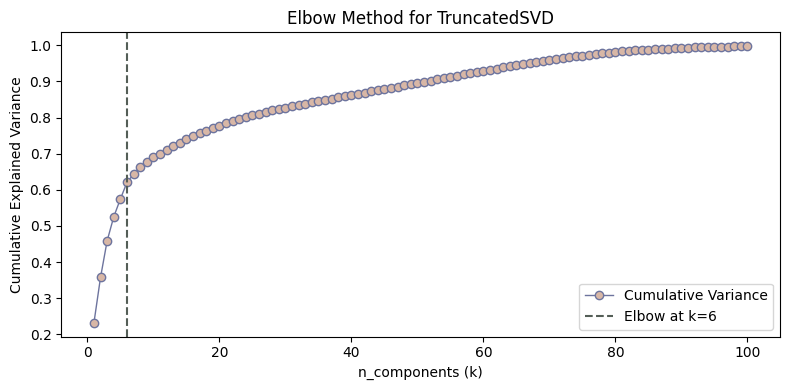

图像已保存到：E:/tongji/truncated_svd.jpg


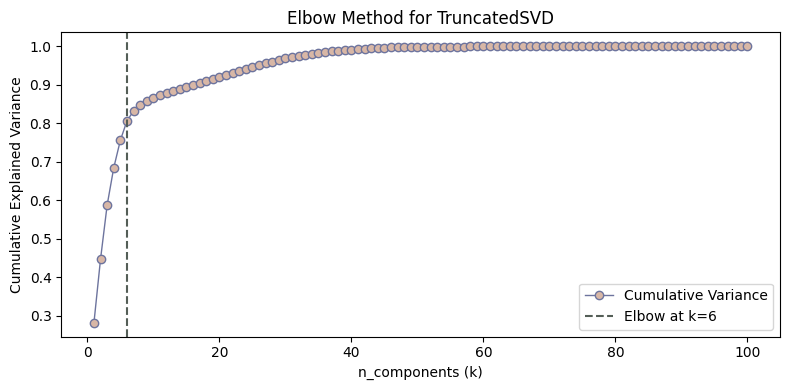

图像已保存到：E:/tongji/truncated_svd_1.jpg


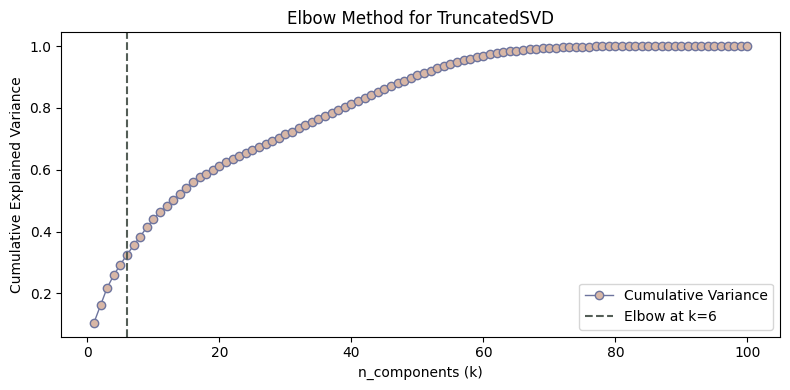

图像已保存到：E:/tongji/truncated_svd_0.jpg
原始词表大小: 128003
新的精简词表大小: 6


In [11]:
elbow_k, cum_var, svd = select_k_elbow(X, max_k=100,   save_path = "E:/tongji/truncated_svd.jpg")
elbow_k_1, cum_var_1, svd_1 = select_k_elbow(X_1, max_k=100,   save_path = "E:/tongji/truncated_svd_1.jpg")
elbow_k_0, cum_var_0, svd_0 = select_k_elbow(X_0, max_k=100,   save_path = "E:/tongji/truncated_svd_0.jpg")

vocab_list = [f"word_{i}" for i in range(X.shape[1])]

#vocab_list = [f"word_{i}" for i in range(X.shape[1])]
#new_vocab_list, new_X = extract_top_p_vocab(X, vocab_list, threshold=0.9)

print(f"原始词表大小: {len(vocab_list)}")
print(f"新的精简词表大小: {elbow_k}")


### 处理部分

In [12]:
# 提取第一主成分向量（长度 = vocab size）
first_component = svd.components_[0]  # shape: (n_features,)
print("第一主成分向量长度：", len(first_component))

# 获取绝对值最大的前 N 个 token（代表这个主成分的核心方向）
N = 20
sorted_indices = np.argsort(np.abs(first_component))[::-1][:N]
top_tokens = [(vocab_list[i], first_component[i]) for i in sorted_indices]

print(f"\n第一主成分中权重最大的前 {N} 个 token：")
for token, weight in top_tokens:
    print(f"{token}\t{weight:.10f}")
    

第一主成分向量长度： 128003

第一主成分中权重最大的前 20 个 token：
word_128000	0.9998962283
word_557	0.0102610243
word_633	0.0048623532
word_879	0.0036498355
word_13	0.0033006896
word_52018	0.0027554033
word_106575	0.0019857190
word_862	0.0018193210
word_748	0.0017509788
word_14251	0.0016590832
word_457	0.0016291880
word_586	0.0015450442
word_1397	0.0014268355
word_74694	0.0014183504
word_4508	0.0011239378
word_394	0.0011192268
word_63075	0.0010714037
word_106890	0.0010191589
word_711	0.0008997741
word_45464	0.0008945328


In [13]:
N = 20  # 每个主成分取前 N 个权重最大 token
num_components = 6

for k in range(num_components):
    component = svd.components_[k]  # 第 k 个主成分向量
    sorted_indices = np.argsort(np.abs(component))[::-1][:N]
    
    print(f"\n 第 {k+1} 个主成分中权重最大的前 {N} 个 token id：")
    for i in sorted_indices:
        token_id = i if i != 128000 else "None"
        print(f"{token_id}\t{component[i]:.10f}")



 第 1 个主成分中权重最大的前 20 个 token id：
None	0.9998962283
557	0.0102610243
633	0.0048623532
879	0.0036498355
13	0.0033006896
52018	0.0027554033
106575	0.0019857190
862	0.0018193210
748	0.0017509788
14251	0.0016590832
457	0.0016291880
586	0.0015450442
1397	0.0014268355
74694	0.0014183504
4508	0.0011239378
394	0.0011192268
63075	0.0010714037
106890	0.0010191589
711	0.0008997741
45464	0.0008945328

 第 2 个主成分中权重最大的前 20 个 token id：
60	0.9999983311
2595	0.0013264903
13	0.0000301839
933	0.0000236952
8	0.0000078954
627	0.0000040904
None	-0.0000030503
320	0.0000024535
334	0.0000014221
198	0.0000011914
5380	0.0000009936
79	0.0000009116
815	0.0000008249
382	0.0000006651
1035	0.0000006442
11	0.0000006056
58417	0.0000005994
2331	0.0000005705
25	0.0000005283
59	0.0000005065

 第 3 个主成分中权重最大的前 20 个 token id：
13	0.9994664192
382	0.0222889706
627	0.0182757135
11	0.0080136778
334	0.0064889747
198	0.0059396219
1306	0.0033455002
None	-0.0033005334
374	0.0032553882
25	0.0027050432
1035	0.0023798188
323	0.002314018

In [14]:
from sklearn.model_selection import GridSearchCV
import os
import tempfile
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# 设置一个 ASCII-only 的临时路径
ascii_temp_dir = "D:/joblib_temp"
os.makedirs(ascii_temp_dir, exist_ok=True)

# 设置 joblib 临时文件夹
os.environ['JOBLIB_TEMP_FOLDER'] = ascii_temp_dir
tempfile.tempdir = ascii_temp_dir


# 假设 svd 是你先前从 TruncatedSVD 拟合后返回的对象
# 将前6个主成分作为特征

X_proj_np = X @ svd.components_[:6].T  # shape = (n_samples, 6)
y_np = y

# —— 定义模型与参数网格 —— 
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0], 'penalty': ['l2'], 'solver': ['saga']}
base_clf = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
grid = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# —— 拟合 GridSearch —— 
print("开始在 CPU 上训练（使用前 6 个主成分） …")
grid.fit(X_proj_np, y_np)

best_model = grid.best_estimator_
print(" Best params:", grid.best_params_)
print("交叉验证最佳准确率：", grid.best_score_)

# —— 默认阈值 0.5 下评估 —— 
y_pred_05 = best_model.predict(X_proj_np)
print("\n[默认阈值 0.5] Accuracy:", accuracy_score(y_np, y_pred_05))
print(classification_report(y_np, y_pred_05, zero_division=0))

# —— 阈值搜索 —— 
probs = best_model.predict_proba(X_proj_np)[:, 1]
thresholds = np.arange(0.0, 1.0 + 0.001, 0.001)

best_t, best_acc = 0.5, 0.0
for t in thresholds:
    y_pred_t = (probs >= t).astype(int)
    acc = accuracy_score(y_np, y_pred_t)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print(f" 最优阈值（按 Accuracy 最大化，步长=0.001）：{best_t:.3f}，对应 Accuracy={best_acc:.4f}")

# —— 最优阈值评估 —— 
y_pred_opt = (probs >= best_t).astype(int)

acc_opt   = accuracy_score(y_np, y_pred_opt)
f1_opt    = f1_score(y_np, y_pred_opt, zero_division=0)
auc_score = roc_auc_score(y_np, probs)

print("\n 最终指标（在最优阈值下，全体样本）：")
print(f"Accuracy: {acc_opt:.4f}")
print(f"F1-score: {f1_opt:.4f}")
print(f"AUC:       {auc_score:.4f}")


开始在 CPU 上训练（使用前 6 个主成分） …
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\周易\AppData\Local\Temp\ipykernel_12708\1817000660.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_proj_np = X @ svd.components_[:6].T  # shape = (n_samples, 6)


 Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
交叉验证最佳准确率： 0.734

[默认阈值 0.5] Accuracy: 0.732
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       143
           1       0.89      0.72      0.79       357

    accuracy                           0.73       500
   macro avg       0.70      0.74      0.71       500
weighted avg       0.78      0.73      0.74       500

 最优阈值（按 Accuracy 最大化，步长=0.001）：0.288，对应 Accuracy=0.8040

 最终指标（在最优阈值下，全体样本）：
Accuracy: 0.8040
F1-score: 0.8676
AUC:       0.7838


In [15]:
# 假设 svd 是已经 fit 好的 TruncatedSVD 模型
# 提取每个主成分中绝对值最大的 token id（即列索引）

num_components = 6  # 前 6 个主成分
top_ids = []

for k in range(num_components):
    component = svd.components_[k]  # shape: (n_features,)
    max_idx = np.argmax(np.abs(component))  # 最大权重的 token id
    max_value = component[max_idx]
    top_ids.append((k + 1, max_idx, max_value))

# 打印每个主成分中的最大 token id 和对应权重
print("每个主成分中权重最大的 token id：")
for pc_id, token_id, weight in top_ids:
    print(f" 第 {pc_id} 个主成分: token_id = {token_id}, weight = {weight:.10f}")


每个主成分中权重最大的 token id：
 第 1 个主成分: token_id = 128000, weight = 0.9998962283
 第 2 个主成分: token_id = 60, weight = 0.9999983311
 第 3 个主成分: token_id = 13, weight = 0.9994664192
 第 4 个主成分: token_id = 570, weight = 0.9991806149
 第 5 个主成分: token_id = 7966, weight = 0.9989504814
 第 6 个主成分: token_id = 8, weight = 0.9992809296


In [16]:
from transformers import PreTrainedTokenizerFast

# 加载本地 tokenizer.json 文件
tokenizer_llama = PreTrainedTokenizerFast(tokenizer_file="E:/token/llama_tokenizer/llama_tokenizer/tokenizer.json")

# 获取 vocab size
print("词表长度（vocab size）：", tokenizer_llama.vocab_size)

# 获取词表内容，按 id 顺序排列成 list
vocab_dict = tokenizer_llama.get_vocab()
sorted_vocab = sorted(vocab_dict.items(), key=lambda x: x[1])
vocab_list = [token for token, _ in sorted_vocab]

#  vocab_list 就是 id 对应的 token 列表
print("前 10 个 token 示例：", vocab_list[:10])



词表长度（vocab size）： 128000
前 10 个 token 示例： ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*']


In [17]:
# 假设 vocab_list 是 tokenizer 的词表，长度等于 svd.components_.shape[1]
# top_token_ids 是你从每个主成分中提取出的最大 token id

top_token_ids = [128000, 60, 13, 570, 7966, 8]  # 示例值（来自前面代码提取）

# 如果你希望 token_id=128000 特殊标记为 'non'
mapped_tokens = ["None" if tid == 128000 else vocab_list[tid] for tid in top_token_ids]

# 打印对应的 token
for tid, token in zip(top_token_ids, mapped_tokens):
    print(f"token_id = {tid}, token = {token}")


token_id = 128000, token = None
token_id = 60, token = ]
token_id = 13, token = .
token_id = 570, token = ).
token_id = 7966, token = }.
token_id = 8, token = )


## KL散度分析

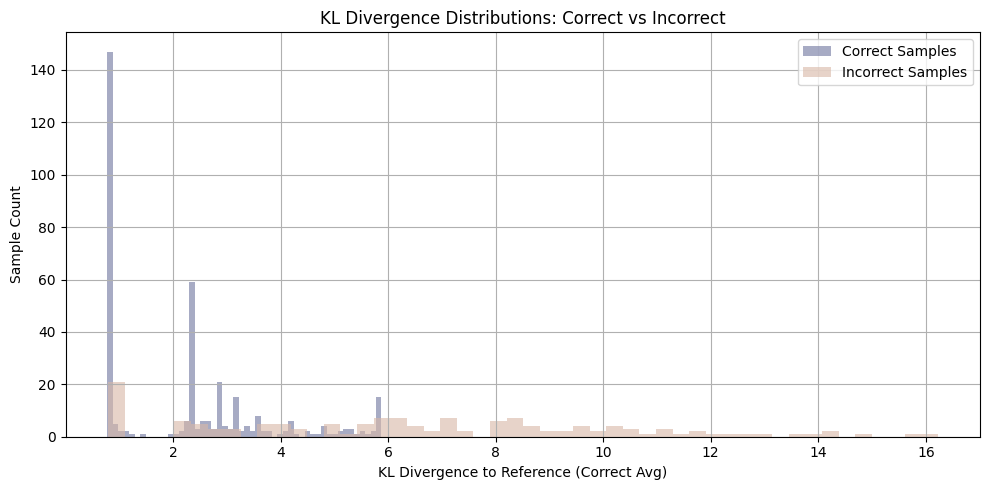

In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 假设 X, X_1, X_0 都已经是概率分布（softmax 后）
# 并且它们都是 torch.tensor 类型，shape = [N, vocab_size]

# Step 1: 构造参考分布（预测正确样本的平均概率分布）
mean_dist = X_1.mean(dim=0)         # shape: [vocab_size]
mean_dist = mean_dist + 1e-12       # 避免除以 0
mean_dist = mean_dist / mean_dist.sum()  # 再归一化确保为概率分布

# Step 2: 批量 KL 散度函数（P 与 Q 都是概率分布）
def batch_kl_divergence(P, Q, eps=1e-12):
    P = P + eps
    P = P / P.sum(dim=1, keepdim=True)  # 归一化（如果略有偏离）
    Q = Q + eps
    Q = Q / Q.sum()                     # 确保参考分布也归一化
    Q = Q.unsqueeze(0).expand_as(P)     # 扩展成与 P 相同 shape
    return (P * (P / Q).log()).sum(dim=1)

# Step 3: 分别计算 KL 散度
kl_all = batch_kl_divergence(X, mean_dist)
kl_pos = batch_kl_divergence(X_1, mean_dist)
kl_neg = batch_kl_divergence(X_0, mean_dist)

# Step 4: 可视化对比分布
plt.figure(figsize=(10, 5))
plt.hist(kl_pos.cpu().numpy(), bins=50, alpha=0.6, label='Correct Samples', color='#6D749E')
plt.hist(kl_neg.cpu().numpy(), bins=50, alpha=0.6, label='Incorrect Samples', color='#D8B7A6')
plt.xlabel("KL Divergence to Reference (Correct Avg)")
plt.ylabel("Sample Count")
plt.title("KL Divergence Distributions: Correct vs Incorrect")
plt.legend()
plt.grid(True)
plt.tight_layout()

#  保存图像
output_path = "E:/tongji/math500_llama_KL_divergence.jpg"
plt.savefig(output_path, dpi=300)

# 显示图像
plt.show()


## TOP-k token分析

In [10]:
import torch

def topk_from_mean_distribution(X_tensor, k=10):
    """
    对输入的 softmax 后概率矩阵求平均分布，然后取 Top-K token。
    :param X_tensor: torch.Tensor，shape = [N, vocab_size]，每行是一个样本的概率分布
    :param k: 取 Top-K
    :return: token_id 和对应的平均概率值
    """
    mean_dist = X_tensor.mean(dim=0)  # shape = [vocab_size]
    topk_probs, topk_ids = torch.topk(mean_dist, k=k, dim=0)
    return topk_ids, topk_probs

#  对预测正确的样本 X_1 做分析
topk_ids_1, topk_probs_1 = topk_from_mean_distribution(X_1, k=10)
print(" 预测正确样本（X_1）的平均分布 Top-K token：")
for i in range(10):
    print(f"  token_id = {topk_ids_1[i].item():6d}, prob = {topk_probs_1[i].item():.6f}")

#  对预测错误的样本 X_0 做分析
topk_ids_0, topk_probs_0 = topk_from_mean_distribution(X_0, k=10)
print("\n 预测错误样本（X_0）的平均分布 Top-K token：")
for i in range(10):
    print(f"  token_id = {topk_ids_0[i].item():6d}, prob = {topk_probs_0[i].item():.6f}")


 预测正确样本（X_1）的平均分布 Top-K token：
  token_id = 128000, prob = 0.339163
  token_id =     60, prob = 0.097895
  token_id =     13, prob = 0.095002
  token_id =    570, prob = 0.055528
  token_id =   7966, prob = 0.040638
  token_id =      8, prob = 0.028071
  token_id =     92, prob = 0.015282
  token_id =    627, prob = 0.009744
  token_id =  13244, prob = 0.008406
  token_id =    334, prob = 0.007296

 预测错误样本（X_0）的平均分布 Top-K token：
  token_id = 128000, prob = 0.114188
  token_id =    284, prob = 0.047831
  token_id =     60, prob = 0.041959
  token_id =      8, prob = 0.032450
  token_id =     11, prob = 0.030373
  token_id =     13, prob = 0.029928
  token_id =     61, prob = 0.024579
  token_id =    382, prob = 0.024295
  token_id =     17, prob = 0.023634
  token_id =    482, prob = 0.022590


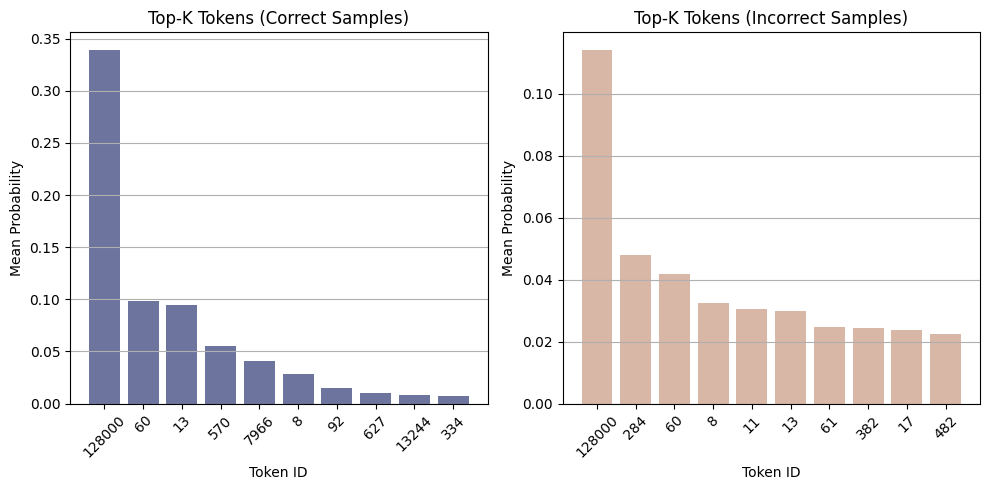

In [11]:
import matplotlib.pyplot as plt

# 转为 numpy
topk_ids_1_np = topk_ids_1.cpu().numpy()
topk_probs_1_np = topk_probs_1.cpu().numpy()
topk_ids_0_np = topk_ids_0.cpu().numpy()
topk_probs_0_np = topk_probs_0.cpu().numpy()

# 创建画布
plt.figure(figsize=(10, 5))

# 子图 1：X_1
plt.subplot(1, 2, 1)
plt.bar(range(10), topk_probs_1_np, tick_label=topk_ids_1_np,color='#6D749E')
plt.title("Top-K Tokens (Correct Samples)")
plt.xlabel("Token ID")
plt.ylabel("Mean Probability")
plt.xticks(rotation=45)
plt.grid(axis='y')

# 子图 2：X_0
plt.subplot(1, 2, 2)
plt.bar(range(10), topk_probs_0_np, tick_label=topk_ids_0_np, color='#D8B7A6')
plt.title("Top-K Tokens (Incorrect Samples)")
plt.xlabel("Token ID")
plt.ylabel("Mean Probability")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.savefig("E:/tongji/math500_topk_comparison.jpg", dpi=300)
plt.show()

In [33]:
token_ids = [128000, 60, 13, 570, 7966, 8, 92, 627, 13244, 334,
             128000, 284, 60, 8, 11, 13, 61, 382, 17, 482]

tokens = ["none" if i == 128000 else vocab_list[i] for i in token_ids]

# 打印结果
for tid, token in zip(token_ids, tokens):
    print(f"ID {tid}: {token}")


ID 128000: none
ID 60: ]
ID 13: .
ID 570: ).
ID 7966: }.
ID 8: )
ID 92: }
ID 627: .Ċ
ID 13244: $.
ID 334: **
ID 128000: none
ID 284: Ġ=
ID 60: ]
ID 8: )
ID 11: ,
ID 13: .
ID 61: ^
ID 382: .ĊĊ
ID 17: 2
ID 482: Ġ-


In [22]:
def extract_topk_probs(probs_np, vocab, k=10):
    """
    输入已经是 softmax 概率矩阵。
    """
    # 如果传入是 numpy，就转 tensor；如果已经是 tensor 就直接用
    if isinstance(probs_np, np.ndarray):
        probs = torch.from_numpy(probs_np).float()
    elif isinstance(probs_np, torch.Tensor):
        probs = probs_np.float()
    else:
        raise TypeError("输入必须是 numpy.ndarray 或 torch.Tensor")

    #  不再 softmax，直接 topk
    topk_probs, topk_indices = torch.topk(probs, k, dim=1)

    # 转换为 token 字符串
    topk_token_strs = []
    for row in topk_indices:
        row_strs = []
        for token_id in row.tolist():
            if token_id < len(vocab):
                row_strs.append(vocab[token_id])
            elif token_id == 128000:
                row_strs.append("<None>")
            elif token_id == 128001:
                row_strs.append("<placeholder-1>")
            elif token_id == 128002:
                row_strs.append("<placeholder-2>")
            elif token_id == 128003:
                row_strs.append("<placeholder-3>")
            else:
                row_strs.append("<unk>")
        topk_token_strs.append(row_strs)

    return topk_indices.numpy(), topk_probs.numpy(), topk_token_strs


In [23]:
# 假设你已经有：X, X_1, X_0 是 numpy 的 logits 数组
# vocab 是 list: vocab[token_id] = "some_word"
k = 10

topk_ids_all, topk_probs_all, topk_strs_all = extract_topk_probs(X, vocab_list, k)
topk_ids_pos, topk_probs_pos, topk_strs_pos = extract_topk_probs(X_1, vocab_list, k)
topk_ids_neg, topk_probs_neg, topk_strs_neg = extract_topk_probs(X_0, vocab_list, k)

word_13: 0.1414
word_1035: 0.0608
word_40: 0.0496
word_497: 0.0363
word_334: 0.0311
word_64: 0.0292
word_35047: 0.0118
word_5519: 0.0097
word_627: 0.0096
word_2181: 0.0085


In [24]:
from collections import Counter

# 所有 top-1 token（每行第一个）
top1_all = [row[0] for row in topk_strs_all]
top1_pos = [row[0] for row in topk_strs_pos]
top1_neg = [row[0] for row in topk_strs_neg]

counts_all = Counter(top1_all)
counts_pos = Counter(top1_pos)
counts_neg = Counter(top1_neg)


### token提取 llama-8b model